# Flair Prediction/Sentiment Natural Language Processing

In this notebook, text posts from r/AmItheAsshole (r/AITA) are processed using various NLP techniques to isolate important word frequencies and patterns. Additionally, sentiment analysis is applied to these data to find interesting patterns/trends within the text posts across different flairs. This analysis only concerns r/AITA posts that are tagged with of the four "primary" flairs, being Not the A-hole (NTA), Asshole (YTA), No A-holes here (NAH), and Everybody Sucks (ESH).

First, we must read in the data from the project S3 bucket and subset it accordingly to only valid (i.e., remove text posts with no body and area also assigned one of the 4 primary flairs).

In [2]:
# Setup - Run only once per Kernel App
%conda install openjdk -y

# install PySpark
%pip install pyspark==3.4.0

# install spark-nlp
%pip install spark-nlp==5.1.3

# restart kernel
from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>")

Solving environment: - 
The environment is inconsistent, please check the package plan carefully
The following packages are causing the inconsistency:

  - defaults/linux-64::anaconda-client==1.7.2=py37_0
  - defaults/noarch::anaconda-project==0.8.4=py_0
  - defaults/linux-64::bokeh==1.4.0=py37_0
  - defaults/noarch::dask==2.11.0=py_0
  - defaults/linux-64::distributed==2.11.0=py37_0
  - defaults/linux-64::spyder==4.0.1=py37_0
  - defaults/linux-64::watchdog==0.10.2=py37_0
failed with initial frozen solve. Retrying with flexible solve.
Solving environment: failed with repodata from current_repodata.json, will retry with next repodata source.
Solving environment: - 
The environment is inconsistent, please check the package plan carefully
The following packages are causing the inconsistency:

  - defaults/linux-64::anaconda-client==1.7.2=py37_0
  - defaults/noarch::anaconda-project==0.8.4=py_0
  - defaults/linux-64::bokeh==1.4.0=py37_0
  - defaults/noarch::dask==2.11.0=py_0
  - defaults/

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import re
import os
import json
import random
import pyspark.sql.functions as F
from sparknlp.base import *
from pyspark.ml import Pipeline
from sparknlp.annotator import *
import pyspark.sql.functions as F
from pyspark.sql import SparkSession
from sparknlp.pretrained import PretrainedPipeline

In [7]:
# Import pyspark and build Spark session
spark = SparkSession.builder \
    .appName("Spark NLP")\
    .master("local[*]")\
    .config("spark.driver.memory","16G")\
    .config("spark.driver.maxResultSize", "0") \
    .config("spark.kryoserializer.buffer.max", "2000M")\
    .config("spark.jars.packages", "com.johnsnowlabs.nlp:spark-nlp_2.12:5.1.3,org.apache.hadoop:hadoop-aws:3.2.2")\
    .config("fs.s3a.aws.credentials.provider", "com.amazonaws.auth.ContainerCredentialsProvider")\
    .getOrCreate()

print(f"Spark version: {spark.version}")
#print(f"SparkNLP version: {sparknlp.version}")

Spark version: 3.4.0


Now we establish an NLP pipeline below to process the data and apply a pretrained sentiment model below:

In [11]:
%%time

# Read in data from project bucket
bucket = "project17-bucket-alex"
output_prefix_data = "project_2022"

# List of 12 directories each containing 1 month of data
directories = ["project_2022_"+str(i)+"/submissions" for i in range(1,13)]

# Iterate through 12 directories and merge each monthly data set to create one big data set
df = None
for directory in directories:
    s3_path = f"s3a://{bucket}/{directory}"
    month_df = spark.read.parquet(s3_path, header = True)

    if df is None:
        df = month_df
    else:
        df = df.union(month_df)

submissions = df

# Here we subset the submissions to only include posts from r/AmItheAsshole for the subsequent analysis
raw_aita = submissions.filter(F.col('subreddit') == "AmItheAsshole")

# filter submissions to remove deleted/removed posts
aita = raw_aita.filter((F.col('selftext') != '[removed]') & (F.col('selftext') != '[deleted]' ))

# Filter submissions to only include posts tagged with the 4 primary flairs
acceptable_flairs = ['Everyone Sucks', 'Not the A-hole', 'No A-holes here', 'Asshole']
df_flairs = aita.where(F.col('link_flair_text').isin(acceptable_flairs))
df_flairs.select("subreddit", "author", "title", "selftext", "created_utc", "num_comments", "link_flair_text").show()
print(f"shape of the subsetted submissions dataframe of appropriately flaired posts is {df_flairs.count():,}x{len(df_flairs.columns)}")

+-------------+--------------------+--------------------+--------------------+-------------------+------------+---------------+
|    subreddit|              author|               title|            selftext|        created_utc|num_comments|link_flair_text|
+-------------+--------------------+--------------------+--------------------+-------------------+------------+---------------+
|AmItheAsshole|       geosunsetmoth|AITA for refusing...|I (NB 19) am auti...|2022-01-22 18:15:30|         425| Not the A-hole|
|AmItheAsshole|           pezewuziz|AITA for charging...|So for a bit of b...|2022-01-22 18:28:39|          56| Everyone Sucks|
|AmItheAsshole|            twilipig|AITA for refusing...|Just a bit of bac...|2022-01-22 18:52:52|          52| Not the A-hole|
|AmItheAsshole|              joreia|AITA for not want...|So I’m (32F) a mo...|2022-01-13 02:17:23|          29| Not the A-hole|
|AmItheAsshole|       BazilbeeChuck|AITA for offering...|\nI (29M) have a ...|2022-01-13 02:32:24|      

In [9]:
import sagemaker
session = sagemaker.Session()
bucket = "project17-bucket-alex"

In [8]:
MODEL_NAME = 'sentimentdl_use_twitter'

documentAssembler = DocumentAssembler().setInputCol("selftext").setOutputCol("document")
    
use = UniversalSentenceEncoder.pretrained(name = "tfhub_use", lang = "en")\
 .setInputCols(["document"])\
 .setOutputCol("sentence_embeddings")


sentimentdl = SentimentDLModel.pretrained(name=MODEL_NAME, lang = "en")\
    .setInputCols(["sentence_embeddings"])\
    .setOutputCol("sentiment")

nlpPipeline = Pipeline(
      stages = [
          documentAssembler,
          use,
          sentimentdl
      ])

tfhub_use download started this may take some time.
Approximate size to download 923.7 MB
[OK!]
sentimentdl_use_twitter download started this may take some time.
Approximate size to download 11.4 MB
[OK!]


In [16]:
%%time
pipelineModel = nlpPipeline.fit(df_flairs)
results = pipelineModel.transform(df_flairs)

CPU times: user 15.3 ms, sys: 1.9 ms, total: 17.2 ms
Wall time: 2.39 s


In [17]:
%%time
results = results.withColumn('sentiment', F.explode(results.sentiment.result))
final_data = results.select('selftext', 'sentence_embeddings','sentiment', "link_flair_text", "num_comments")
final_data.persist()
final_data.show()

+--------------------+--------------------+---------+---------------+------------+
|            selftext| sentence_embeddings|sentiment|link_flair_text|num_comments|
+--------------------+--------------------+---------+---------------+------------+
|I (NB 19) am auti...|[{sentence_embedd...| negative| Not the A-hole|         425|
|So for a bit of b...|[{sentence_embedd...| negative| Everyone Sucks|          56|
|Just a bit of bac...|[{sentence_embedd...| negative| Not the A-hole|          52|
|So I’m (32F) a mo...|[{sentence_embedd...| negative| Not the A-hole|          29|
|\nI (29M) have a ...|[{sentence_embedd...| positive|        Asshole|         470|
|So this isn’t sup...|[{sentence_embedd...| negative| Not the A-hole|          20|
|In December of 20...|[{sentence_embedd...| negative| Not the A-hole|          33|
|Please don't post...|[{sentence_embedd...| negative| Not the A-hole|          37|
|I’m currently a c...|[{sentence_embedd...| negative| Not the A-hole|          22|
|So 

In [ ]:
final_data.printSchema()

Now that we have applied a pretrained sentiment model to our r/AITA reddit posts, we can now summarize these results in a table by flair. We will group by each flair and sentiment type.

In [18]:
%%time
cols = ['link_flair_text', 'sentiment']
sum_counts = final_data.groupBy(cols).count()
sum_counts.show()

+---------------+---------+-----+
|link_flair_text|sentiment|count|
+---------------+---------+-----+
|        Asshole| positive| 1087|
|No A-holes here| positive|  390|
| Not the A-hole| negative|79541|
|        Asshole| negative|13995|
| Everyone Sucks| positive|  203|
|No A-holes here|  neutral|  126|
| Not the A-hole| positive| 4310|
|        Asshole|  neutral|  383|
| Not the A-hole|  neutral| 1643|
| Everyone Sucks|  neutral|   74|
|No A-holes here| negative| 4675|
| Everyone Sucks| negative| 3960|
+---------------+---------+-----+



In [77]:
# We can save this dataframe in our repo for later visualization and summarization
df_sent_baseline = sum_counts.toPandas()
df_sent_baseline.to_parquet("../../data/nlp-data/aita_sentiments.parquet")

In [27]:
df_sent_baseline.sort_values(["link_flair_text","sentiment"])

,link_flair_text,sentiment,count
3,Asshole,negative,13995
7,Asshole,neutral,383
0,Asshole,positive,1087
11,Everyone Sucks,negative,3960
9,Everyone Sucks,neutral,74
4,Everyone Sucks,positive,203
10,No A-holes here,negative,4675
5,No A-holes here,neutral,126
1,No A-holes here,positive,390
2,Not the A-hole,negative,79541


We can visualize the results of the sentiment analysis by flair in the chart below:

In [78]:
df_pivot = df_sent_baseline.pivot(index = "link_flair_text", columns = "sentiment", values = "count")
df_pivot.to_parquet("../../data/nlp-data/aita_sentiments_pivoted.parquet")

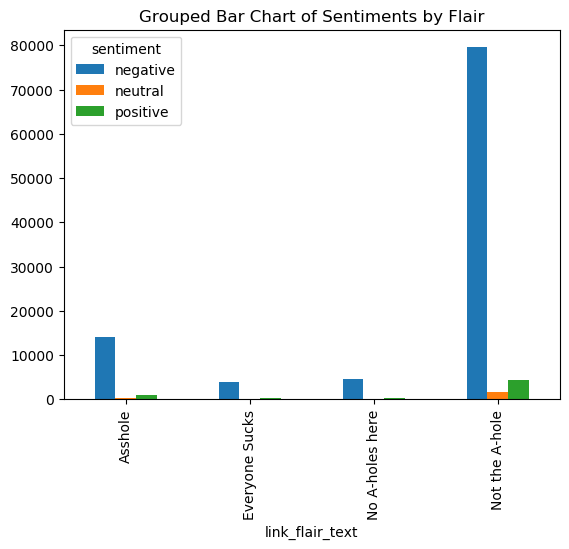

In [55]:
df_pivot.reset_index().plot(x = "link_flair_text",
       kind = "bar",
       stacked = False,
       title = "Grouped Bar Chart of Sentiments by Flair")

plt.show()

We can see that the plot above is not easily readable, so we will convert the counts into relative frequencies to compare the proportion of each flair type with positive, negative, and neutral sentiments.

In [56]:
row_sums = df_pivot.sum(axis=1)
df_pivot_prop = df_pivot.div(row_sums, axis=0)
df_pivot_prop

sentiment,negative,neutral,positive
link_flair_text,,,
Asshole,0.904947,0.024766,0.070288
Everyone Sucks,0.934624,0.017465,0.047911
No A-holes here,0.900597,0.024273,0.075130
Not the A-hole,0.930369,0.019218,0.050413


Now with the relative frequencies acquired, we can now create a more legible and useful grouped bar chart of the sentiment occurrences by flair type in r/AITA.

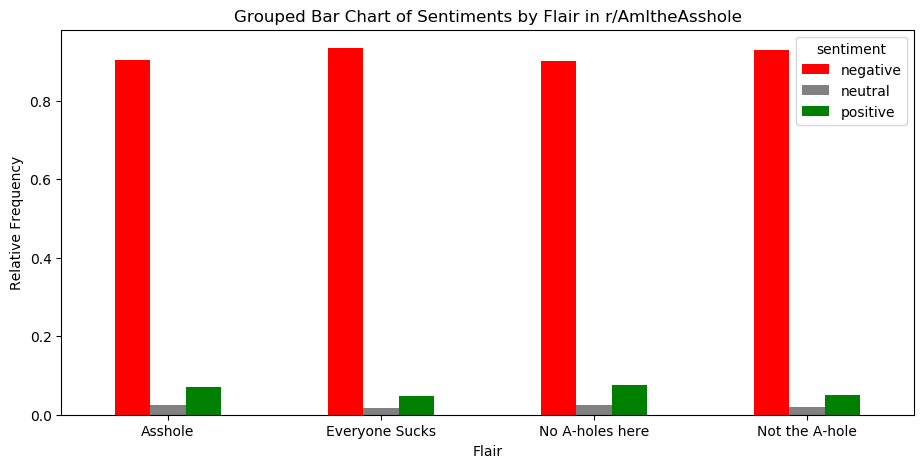

In [79]:
df_pivot_prop.reset_index().plot(x = "link_flair_text", 
                                 kind = "bar", stacked = False, 
                                 title = "Grouped Bar Chart of Sentiments by Flair in r/AmItheAsshole", 
                                 xlabel = "Flair",
                                ylabel = "Relative Frequency",
                                rot = 0,
                                figsize = (11,5),
                                color = ["red","gray", "green"])
plt.savefig("../../website-source/img/flair_sentiments_barchart.png")
plt.show()

As we can see above, the pretrained sentiment model identified the overwhelming majority of posts as having "negative" sentiment scores across all flair types. Next, we will analyze these sentiments with respect to the engagement a post receives, measured by the number of comments on the post. Below, we attempt to find relationships between sentiment score and number of comments.

In [80]:
# Using these data we will conduct our analysis
final_data.show()

+--------------------+--------------------+---------+---------------+------------+
|            selftext| sentence_embeddings|sentiment|link_flair_text|num_comments|
+--------------------+--------------------+---------+---------------+------------+
|I (NB 19) am auti...|[{sentence_embedd...| negative| Not the A-hole|         425|
|So for a bit of b...|[{sentence_embedd...| negative| Everyone Sucks|          56|
|Just a bit of bac...|[{sentence_embedd...| negative| Not the A-hole|          52|
|So I’m (32F) a mo...|[{sentence_embedd...| negative| Not the A-hole|          29|
|\nI (29M) have a ...|[{sentence_embedd...| positive|        Asshole|         470|
|So this isn’t sup...|[{sentence_embedd...| negative| Not the A-hole|          20|
|In December of 20...|[{sentence_embedd...| negative| Not the A-hole|          33|
|Please don't post...|[{sentence_embedd...| negative| Not the A-hole|          37|
|I’m currently a c...|[{sentence_embedd...| negative| Not the A-hole|          22|
|So 

In [87]:
%%time
cols = ['link_flair_text', 'sentiment']
avg_engage = final_data.groupBy(cols).agg(F.mean('num_comments').alias('avg_num_comments'))
# Convert to pandas
df_engage = avg_engage.toPandas()
df_engage.sort_values(['link_flair_text', 'sentiment'])

CPU times: user 14.8 ms, sys: 415 µs, total: 15.2 ms
Wall time: 1.45 s


,link_flair_text,sentiment,avg_num_comments
3,Asshole,negative,242.204930
7,Asshole,neutral,225.590078
0,Asshole,positive,265.443422
11,Everyone Sucks,negative,104.879040
9,Everyone Sucks,neutral,172.310811
4,Everyone Sucks,positive,183.610837
10,No A-holes here,negative,63.152513
5,No A-holes here,neutral,67.738095
1,No A-holes here,positive,90.923077
2,Not the A-hole,negative,105.068179


We can see the average engagement by sentiment type in the table above. Next, we transform these data to a more digestible format that is more conducive to plotting.

In [92]:
df_pivot = df_engage.pivot(index = "link_flair_text", columns = "sentiment", values = "avg_num_comments")
df_pivot.to_parquet("../../data/nlp-data/aita_sentiments_engagements.parquet")
df_pivot

sentiment,negative,neutral,positive
link_flair_text,,,
Asshole,242.204930,225.590078,265.443422
Everyone Sucks,104.879040,172.310811,183.610837
No A-holes here,63.152513,67.738095,90.923077
Not the A-hole,105.068179,128.069385,148.397912


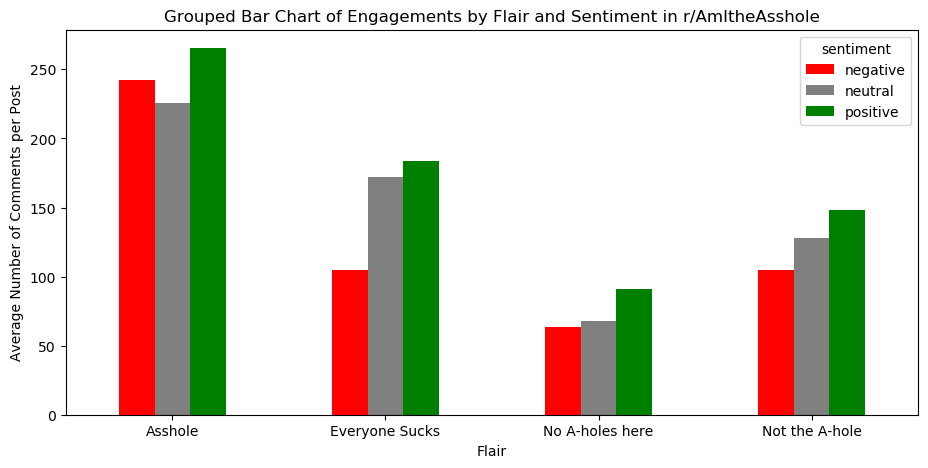

In [94]:
df_pivot.reset_index().plot(x = "link_flair_text", 
                                 kind = "bar", stacked = False, 
                                 title = "Grouped Bar Chart of Engagements by Flair and Sentiment in r/AmItheAsshole", 
                                 xlabel = "Flair",
                                ylabel = "Average Number of Comments per Post",
                                rot = 0,
                                figsize = (11,5),
                                color = ["red","gray", "green"])
plt.savefig("../../website-source/img/flair_engagements_barchart.png")
plt.show()

The code below attempts to use a Sagemaker Processing Job to process and analyze these data from r/AITA. However there were some complications so we opted to analyze these data interactively in a Sagemaker Studio notebook above.

In [6]:
import sagemaker
session = sagemaker.Session()
bucket = "project17-bucket-alex"
!wget -qO- https://s3.amazonaws.com/auxdata.johnsnowlabs.com/public/jars/spark-nlp-assembly-5.1.3.jar | aws s3 cp - s3://{bucket}/lab8/spark-nlp-assembly-5.1.3.jar
!aws s3 ls s3://{bucket}/lab8/spark-nlp-assembly-5.1.3.jar

2023-11-18 05:32:14  708534094 spark-nlp-assembly-5.1.3.jar


In [3]:
%%writefile ./flair-process.py

import os
import sys
import logging
import argparse

# Import pyspark and build Spark session
from pyspark.sql.functions import *
from pyspark.sql.types import (
    DoubleType,
    IntegerType,
    StringType,
    StructField,
    StructType,
)

import json
import sparknlp
import numpy as np
import pandas as pd
from sparknlp.base import *
from pyspark.ml import Pipeline
from sparknlp.annotator import *
import pyspark.sql.functions as F
from pyspark.sql import SparkSession
from sparknlp.pretrained import PretrainedPipeline

logging.basicConfig(format='%(asctime)s,%(levelname)s,%(module)s,%(filename)s,%(lineno)d,%(message)s', level=logging.DEBUG)
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
logger.addHandler(logging.StreamHandler(sys.stdout))

def main():
    parser = argparse.ArgumentParser(description="app inputs and outputs")
    parser.add_argument("--s3_dataset_path", type=str, help="Path of dataset in S3")
    parser.add_argument("--s3_output_bucket", type=str, help="s3 output bucket")
    parser.add_argument("--s3_output_key_prefix", type=str, help="s3 output key prefix")
    args = parser.parse_args()
    logger.info(f"args={args}")
    
    spark = SparkSession.builder \
    .appName("Spark NLP")\
    .config("spark.driver.memory","16G")\
    .config("spark.driver.maxResultSize", "0") \
    .config("spark.kryoserializer.buffer.max", "2000M")\
    .config("spark.jars.packages", "com.johnsnowlabs.nlp:spark-nlp_2.12:5.1.3")\
    .getOrCreate()
    
    logger.info(f"Spark version: {spark.version}")
    logger.info(f"sparknlp version: {sparknlp.version()}")
    
    # This is needed to save RDDs which is the only way to write nested Dataframes into CSV format
    sc = spark.sparkContext
    sc._jsc.hadoopConfiguration().set(
        "mapred.output.committer.class", "org.apache.hadoop.mapred.FileOutputCommitter"
    )

    # Defining the schema corresponding to the input data. The input data does not contain the headers
    schema = StructType(
        [
            StructField("ID", StringType(), True),
            StructField("Content", StringType(), True),
            StructField("Summary", StringType(), True),
            StructField("Dataset", StringType(), True)
        ]
    )
    
    # Downloading the data from S3 into a Dataframe
    logger.info(f"going to read {args.s3_dataset_path}")
    #df = spark.read.parquet(args.s3_dataset_path, header=True, schema=schema)
    #df = df.repartition(64)
    
        # Read in data from project bucket
    #bucket = "project17-bucket-alex"
    #output_prefix_data = "project_2022"

    # List of 12 directories each containing 1 month of data
    directories = ["project_2022_"+str(i)+"/submissions" for i in range(1,13)]

    # Iterate through 12 directories and merge each monthly data set to create one big data set
    df = None
    for directory in directories:
        s3_path = f"s3a://{bucket}/{directory}"
        month_df = spark.read.parquet(s3_path, header = True)

        if df is None:
            df = month_df
        else:
            df = df.union(month_df)
    logger.info(f"finished reading files...")
    
    submissions = df

    # Here we subset the submissions to only include posts from r/AmItheAsshole for the subsequent analysis
    raw_aita = submissions.filter(F.col('subreddit') == "AmItheAsshole")

    # filter submissions to remove deleted/removed posts
    aita = raw_aita.filter((F.col('selftext') != '[removed]') & (F.col('selftext') != '[deleted]' ))

    # Filter submissions to only include posts tagged with the 4 primary flairs
    acceptable_flairs = ['Everyone Sucks', 'Not the A-hole', 'No A-holes here', 'Asshole']
    df_flairs = aita.where(F.col('link_flair_text').isin(acceptable_flairs))
    df_flairs.select("subreddit", "author", "title", "selftext", "created_utc", "num_comments", "link_flair_text").show()
    print(f"shape of the subsetted submissions dataframe of appropriately flaired posts is {df_flairs.count():,}x{len(df_flairs.columns)}")
    df = df_flairs

    
    # get count
    row_count = df.count()
    # create a temp rdd and save to s3
    line = [f"count={row_count}"]
    logger.info(line)
    l = [('count', row_count)]
    tmp_df = spark.createDataFrame(l)
    s3_path = "s3://" + os.path.join(args.s3_output_bucket, args.s3_output_key_prefix, "count")
    logger.info(f"going to save count to {s3_path}")
    # we want to write to a single file so coalesce
    tmp_df.coalesce(1).write.format('csv').option('header', 'false').mode("overwrite").save(s3_path)
    
    #df = df\
    #.withColumn('politics', F.col("Content").rlike("""(?i)politics|(?i)political|(?i)senate|(?i)democrats|(?i)republicans|(?i)government|(?i)president|(?i)prime minister|(?i)congress"""))\
    #.withColumn('sports', F.col("Content").rlike("""(?i)sport|(?i)ball|(?i)coach|(?i)goal|(?i)baseball|(?i)football|(?i)basketball"""))\
    #.withColumn('arts', F.col("Content").rlike("""(?i)art|(?i)painting|(?i)artist|(?i)museum|(?i)photography|(?i)sculpture"""))\
    #.withColumn('history', F.col("Content").rlike("""(?i)history|(?i)historical|(?i)ancient|(?i)archaeology|(?i)heritage|(?i)fossil""")).persist()
    
    #categories = ['politics', 'arts', 'sports', 'history']
    #for c in categories:
    #    df_soln = df.groupBy(c).count() #.toPandas().to_dict(orient='records')        
    #    s3_path = "s3://" + os.path.join(args.s3_output_bucket, args.s3_output_key_prefix, c)
    #    logger.info(f"going to save dataframe to {s3_path}")
    #    # we want to write to a single file so coalesce
    #    df_soln.coalesce(1).write.format('csv').option('header', 'false').mode("overwrite").save(s3_path)

    # sentiment analysis
    MODEL_NAME = 'sentimentdl_use_twitter'
    logger.info(f"setting up an nlp pipeline with model={MODEL_NAME}")
    documentAssembler = DocumentAssembler()\
    .setInputCol("selftext")\
    .setOutputCol("document")
    
    use = UniversalSentenceEncoder.pretrained(name="tfhub_use", lang="en")\
     .setInputCols(["document"])\
     .setOutputCol("sentence_embeddings")

    sentimentdl = SentimentDLModel.pretrained(name=MODEL_NAME, lang="en")\
    .setInputCols(["sentence_embeddings"])\
    .setOutputCol("sentiment")

    nlp_pipeline = Pipeline(
      stages = [
          documentAssembler,
          use,
          sentimentdl
      ])
    logger.info(f"going to fit and transform pipeline on dataframe")
    pipeline_model = nlp_pipeline.fit(df)
    results = pipeline_model.transform(df)
    logger.info(f"done with fit and transform pipeline on dataframe")
    
    results=results.withColumn('sentiment', F.explode(results.sentiment.result))
    final_data=results.select("subreddit", "author", "title", "selftext", "created_utc", "num_comments", "link_flair_text",'sentiment')
    final_data.persist()
    #final_data.show()
    cols = ['link_flair_text', 'sentiment']
    #logger.info(f"going to run a group by and count on columns={cols}")
    sum_counts = final_data.groupBy(cols).count()
    logger.info(f"going to convert sum_counts to dict")
    df_sent_baseline = sum_counts #.toPandas().to_dict(orient='records')
    logger.info(df_sent_baseline)
    s3_path = "s3://" + os.path.join(args.s3_output_bucket, args.s3_output_key_prefix, "sentiment_baseline")
    logger.info(f"going to save dataframe to {s3_path}")
    # we want to write to a single file so coalesce
    df_sent_baseline.coalesce(1).write.format('csv').option('header', 'false').mode("overwrite").save(s3_path)
    logger.info("all done")
    
if __name__ == "__main__":
    main()

Overwriting ./flair-process.py


In [5]:
%%time
import boto3
import sagemaker
from sagemaker.spark.processing import PySparkProcessor

account_id = boto3.client('sts').get_caller_identity()['Account']

# Setup the PySpark processor to run the job. Note the instance type and instance count parameters. SageMaker will create these many instances of this type for the spark job.
role = sagemaker.get_execution_role()
spark_processor = PySparkProcessor(
    base_job_name="sm-spark-project17",
    image_uri=f"{account_id}.dkr.ecr.us-east-1.amazonaws.com/sagemaker-spark:latest",
    role=role,
    instance_count=8,
    instance_type="ml.m5.xlarge",
    max_runtime_in_seconds=3600,
)

# s3 paths
session = sagemaker.Session()
bucket = "project17-bucket-alex"
s3_dataset_path = f"s3://{bucket}"
print(f"account_id={account_id}, s3_dataset_path={s3_dataset_path}")
output_prefix_data = f"flairs/data"
output_prefix_logs = f"flairs/spark_logs"


# run the job now, the arguments array is provided as command line to the Python script (Spark code in this case).
spark_processor.run(
    submit_app="./flair-process.py",
    submit_jars=[f"s3://{bucket}/lab8/spark-nlp-assembly-5.1.3.jar"],
    arguments=[
        "--s3_dataset_path",
        s3_dataset_path,
        "--s3_output_bucket",
        bucket,
        "--s3_output_key_prefix",
        output_prefix_data,
    ],
    spark_event_logs_s3_uri="s3://{}/{}/spark_event_logs".format(bucket, output_prefix_logs),
    logs=False,
)

account_id=862339729993, s3_dataset_path=s3://project17-bucket-alex


INFO:sagemaker:Creating processing-job with name sm-spark-project17-2023-11-18-13-24-48-488


.....................................................................................*

UnexpectedStatusException: Error for Processing job sm-spark-project17-2023-11-18-13-24-48-488: Failed. Reason: AlgorithmError: See job logs for more information